In [51]:
# загружаем библиотеки 
import pandas as pd
import numpy as np
df = pd.read_csv(r'C:\Moscow City Hack\data.csv')

Для начала мы хотим понять, с чем мы работаем. 

Описание полей: 
1. Client_id - идентификатор клиента 
2. Gender - пол 
3. Birth_date - дата рождения клиента 
4. Create_dt - дата создания счета/дата создания заявки 
5. nonresident_flag - флаг резидента 
6. businessman_flag - флаг бизнесмена 
7. city - город 
8. term - соглашение об основных условиях сделки 
9. contract_sum - сумма контракта
10. product_category_name - тип продукта (два значения - договор на дк и кк)
11. card_id - идентификатор карты 
12. card_type_name - тип карты 
13. start_date
14. fact_close_date - дата закрытия счет/карты/продукта
15. purchase_sum 
16. purchase_count
17. current_balance_avg_sum
18. current_balance_sum
19. current_debit_turn_sum
20. current_credit_turn_sum
21. card_type

Бинарные категориальные  признаки: 
1. Gender 
2. Nonresident_flg 
3. Businessman_flag 


Категориальные небинарные: 
1. City 
2. product_category_name
3. card_type
4. card_type_name


In [52]:
df.drop_duplicates(inplace = True)

In [53]:
df.shape

(240397, 21)

In [54]:
print("Количество пропущенных значений после обработки пропусков в таблице:")
df.isna().sum().to_frame().sort_values(0, ascending = False).T

Количество пропущенных значений после обработки пропусков в таблице:


,term,fact_close_date,start_date,card_type_name,city,client_id,current_credit_turn_sum,current_debit_turn_sum,current_balance_sum,current_balance_avg_sum,...,purchase_sum,card_id,gender,product_category_name,contract_sum,businessman_flag,nonresident_flag,create_date,birth_date,card_type
0,240397,162551,21322,21322,751,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
del df['term']
del df['card_id']
del df['client_id']

In [56]:
df['nonresident_flag'].value_counts()

R    235445
N      4952
Name: nonresident_flag, dtype: int64

In [57]:
df['product_category_name'].value_counts()

Договор на текущий счет для дебетовой карты    225522
Кредитная карта                                 14875
Name: product_category_name, dtype: int64

In [58]:
# преобразование небинарных признаков
one_hot_df = pd.get_dummies(df, 
                            columns=['card_type_name', 'city'], 
                            drop_first=False)
one_hot_df.head()

,gender,birth_date,create_date,nonresident_flag,businessman_flag,contract_sum,product_category_name,start_date,fact_close_date,purchase_sum,...,city_Химки,city_Челябинск,city_Череповец,city_Чишмы,city_Чусовой,city_Юрга,city_Языково,city_Янаул,city_Янгантау,city_Ярославль
0,Ж,1985,2020-01-29,R,0,0.0,Договор на текущий счет для дебетовой карты,2019.0,2021.0,16600.0,...,0,0,0,0,0,0,0,0,0,0
1,М,1951,2009-09-24,R,0,0.0,Договор на текущий счет для дебетовой карты,2019.0,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Ж,1982,2006-12-25,R,0,0.0,Договор на текущий счет для дебетовой карты,NaN,NaN,0.0,...,0,0,0,0,0,1,0,0,0,0
3,М,1955,2011-04-15,R,0,0.0,Договор на текущий счет для дебетовой карты,2021.0,NaN,24300.0,...,0,0,0,0,0,0,0,0,0,0
4,М,1955,2011-04-15,R,0,0.0,Договор на текущий счет для дебетовой карты,2018.0,2022.0,24300.0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
one_hot_df.shape

(240397, 193)

In [60]:

from datetime import datetime, date
today = date.today()
one_hot_df['Year'] = pd.to_datetime(one_hot_df['birth_date'], format='%Y')
one_hot_df['year'] = pd. DatetimeIndex(one_hot_df['Year']).year
one_hot_df['age'] = today.year - one_hot_df['year']
del one_hot_df['Year']
del one_hot_df['year']
del one_hot_df['birth_date']

In [61]:
one_hot_df['life_account'] = one_hot_df['fact_close_date'] - one_hot_df['start_date']
one_hot_df.loc[one_hot_df["gender"] == "М","gender"] = 1
one_hot_df.loc[one_hot_df["gender"] == "Ж","gender"] = 0
one_hot_df.loc[one_hot_df["nonresident_flag"] == "R","nonresident_flag"] = 0
one_hot_df.loc[one_hot_df["nonresident_flag"] == "N","nonresident_flag"] = 1

one_hot_df.loc[one_hot_df['card_type'] == "dc","card_type"] = 1
one_hot_df.loc[one_hot_df['card_type'] == "cc","card_type"] = 0


one_hot_df.loc[one_hot_df['product_category_name'] == "Кредитная карта","product_category_name"] = 1
one_hot_df.loc[one_hot_df['product_category_name'] == "Договор на текущий счет для дебетовой карты",'product_category_name'] = 0

one_hot_df[['start_date', 'fact_close_date']] = np.where(one_hot_df[['start_date', 'fact_close_date']].isnull(), 0, 1)

In [62]:
one_hot_df['year'] = pd. DatetimeIndex(one_hot_df['create_date']).year

In [63]:
del one_hot_df['create_date']

In [64]:
one_hot_df.fillna(0, inplace=True)

Бинарные категориальные признаки: 


## Кластеризация 

In [65]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(init='k-means++',  max_iter=400, random_state=42)
kmeans_model.fit(one_hot_df)

KMeans(max_iter=400, random_state=42)

In [66]:
def try_different_clusters(K, data):
       
    cluster_values = list(range(1, K+1))
    inertias=[]
    
    for c in cluster_values:
        model = KMeans(n_clusters = c,init='k-means++',max_iter=400,random_state=42)
        model.fit(data)
        inertias.append(model.inertia_)
    
    return inertias

In [67]:
outputs = try_different_clusters(7, one_hot_df)
distances = pd.DataFrame({"clusters": list(range(1, 8)),"sum of squared distances": outputs})

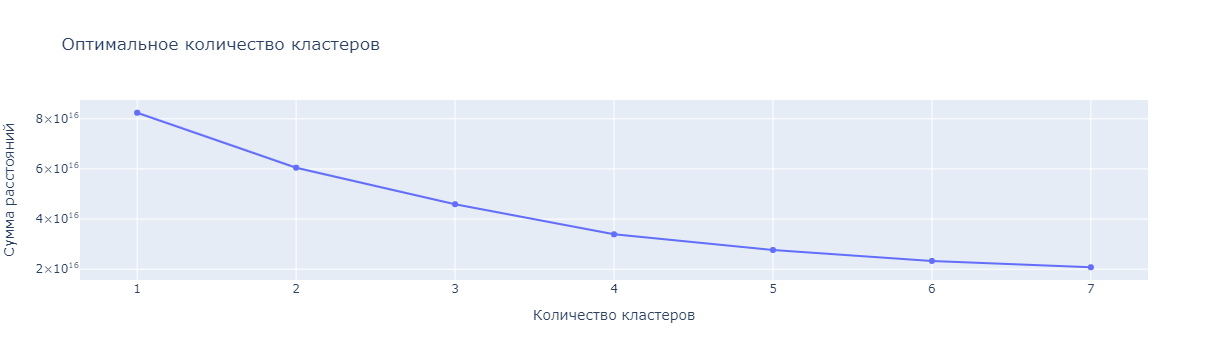

In [68]:
import plotly.graph_objects as go
figure = go.Figure()
figure.add_trace(go.Scatter(x=distances["clusters"], y=distances["sum of squared distances"]))

figure.update_layout(xaxis = dict(tick0 = 1,dtick = 1,tickmode = 'linear'),                  
                  xaxis_title="Количество кластеров",
                  yaxis_title="Сумма расстояний",
                  title_text="Оптимальное количество кластеров")
figure.show()

In [69]:
kmeans_model_new = KMeans(n_clusters = 4,init='k-means++',max_iter=400,random_state=42)
kmeans_model_new.fit_predict(one_hot_df)

array([1, 1, 1, ..., 1, 1, 1])

In [70]:
one_hot_df["clusters"] = kmeans_model_new.labels_

In [71]:
one_hot_df["clusters"].value_counts()

1    236449
0      3816
3       127
2         5
Name: clusters, dtype: int64

In [72]:

one_hot_df.loc[one_hot_df['clusters'] == 0,"clusters"] = 'Кластер 0'
one_hot_df.loc[one_hot_df['clusters'] == 1,"clusters"] = 'Кластер 1'
one_hot_df.loc[one_hot_df['clusters'] == 2,"clusters"] = 'Кластер 2'
one_hot_df.loc[one_hot_df['clusters'] == 3,"clusters"] = 'Кластер 3'

In [73]:
bins=[18, 25, 35, 44, 54, 64, 65]
labels=['18-24', '25-34', '35-44', '45-54', '55-64', '>65']
one_hot_df['age_group'] = pd.cut(one_hot_df['age'], bins, labels=labels)

In [74]:
import collections
dict_without_order_age =  dict(one_hot_df['age_group'].value_counts(1))
dict_without_order_gender =  dict(one_hot_df['gender'].value_counts(1))
od_gender = collections.OrderedDict(sorted(dict_without_order_gender.items()))
dict_without_order_resident =  dict(one_hot_df['nonresident_flag'].value_counts(1))
od_resident = collections.OrderedDict(sorted(dict_without_order_resident.items()))

In [75]:
empty_dict_age = dict.fromkeys(['18-24', '25-34', '35-44', '45-54', '55-64', '>65'])
empty_dict_gender = dict.fromkeys(['0', '1'])
empty_dict_resident = dict.fromkeys(['0', '1'])

In [76]:

empty_dict_age.update(dict_without_order_age)
od_gender.update(dict_without_order_gender)
od_resident.update(empty_dict_resident)

In [77]:
age_distr = list(empty_dict_age.values())
gender_distr = list(od_gender.values())
resident_distr = list(od_resident.values())

In [78]:
one_hot_df_clusters = list(set(one_hot_df['clusters']))
clusters = []
age = []
gender = []
residents = []
for i in one_hot_df_clusters:
  df_cluster = one_hot_df[one_hot_df['clusters'] == i]
  dict_without_order_age =  dict(df_cluster['age_group'].value_counts(1))
  dict_without_order_gender =  dict(df_cluster['gender'].value_counts(1))
  od_gender = collections.OrderedDict(sorted(dict_without_order_gender.items()))
  dict_without_order_resident =  dict(df_cluster['nonresident_flag'].value_counts(1))
  #od_resident = collections.OrderedDict(sorted(dict_without_order_resident.items()))
  empty_dict_age = dict.fromkeys(['18-24', '25-34', '35-44', '45-54', '55-64', '>65'])
  empty_dict_gender = dict.fromkeys(['0', '1'])
  empty_dict_resident = dict.fromkeys(['0', '1'])
  empty_dict_age.update(dict_without_order_age)
  od_gender.update(dict_without_order_gender)
  #od_resident.update(empty_dict_resident)
  age_distr = list(empty_dict_age.values())
  age_dis = [0 if v is None else v for v in age_distr]
  gender_distr = list(od_gender.values())
  gender_dis = [0 if v is None else v for v in gender_distr]
  resident_distr = list(dict_without_order_resident.values())
  resident_dis = [0 if v is None else v for v in  resident_distr]

  clusters.append(i)
  age.append(age_dis)
  gender.append(gender_dis)  
  residents.append(resident_dis)

In [79]:


d = {'cluster': clusters, 'age_cluster': age, 'gender_cluster':gender, 'residents_cluster':residents}
df = pd.DataFrame(data=d)
df

,cluster,age_cluster,gender_cluster,residents_cluster
0,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]"
1,Кластер 0,"[0.006620428751576293, 0.12042875157629256, 0....","[0.4588574423480084, 0.5411425576519916]","[0.9787735849056604, 0.02122641509433962]"
2,Кластер 2,"[0.0, 0.0, 0.8, 0.2, 0.0, 0.0]",[1.0],[1.0]
3,Кластер 3,"[0.0, 0.0, 0.3217391304347826, 0.4260869565217...","[0.2440944881889764, 0.7559055118110236]",[1.0]


In [80]:
data_media = pd.DataFrame(columns=["site", "age", "gender", "resident"])

In [81]:
data_media.loc[len(data_media.index)] = ['VK', [0.1987, 0.3338, 0.1863, 0.1419, 0.0956, 0.0437], [0.4437, 0.5563], [0.8238, 0.1762]]
data_media.loc[len(data_media.index)] = ['TELEGRAM', [0.27, 0.38, 0.306, 0.213, 0.1, 0.085], [0.39, 0.61], [0.6, 0.4]]
data_media.loc[len(data_media.index)] = ['Одноклассники', [0.1647, 0.2854, 0.1959, 0.1605, 0.1307, 0.0628], [0.5079, 0.4921], [0.735, 0.265]]
data_media.loc[len(data_media.index)] = ['Яндекс Новости', [0.1522, 0.355, 0.2103, 0.1435, 0.0958, 0.0432], [0.4604, 0.5396], [0.9169, 0.083]]
data_media.loc[len(data_media.index)] = ['РБК', [0.1085, 0.3158, 0.2127, 0.1699, 0.1265, 0.0665], [0.4311, 0.5689], [0.8897, 0.11]]
data_media.loc[len(data_media.index)] = ['VC.RU', [0.163, 0.4295, 0.1968, 0.1155, 0.0655, 0.0297], [0.3912, 0.6088], [0.6725, 0.3275]]
data_media.loc[len(data_media.index)] = ['НОВАЯ ГАЗЕТА', [0.1219, 0.2939, 0.1938, 0.1666, 0.1364, 0.0874], [0.4124, 0.5876], [0.5999, 0.4001]]
data_media.loc[len(data_media.index)] = ['Forbes RU', [0.113, 0.3217, 0.1977, 0.1623, 0.1321, 0.0731], [0.4135, 0.5865], [0.7966, 0.2034]]
data_media.loc[len(data_media.index)] = ['Хабр', [0.172, 0.4475, 0.1937, 0.1025, 0.0569, 0.0275], [0.301, 0.699], [0.6852, 0.3148]]
data_media.loc[len(data_media.index)] = ['НОЖ', [0.1863, 0.352, 0.1804, 0.1461, 0.0948, 0.0403], [0.4872, 0.5128], [0.7327, 0.2673]]
data_media.loc[len(data_media.index)] = ['YouTube', [0.1818, 0.4118, 0.1879, 0.119, 0.069, 0.0305], [0.4264, 0.5736], [0.7531, 0.2469]]
data_media.loc[len(data_media.index)] = ['Rutube', [0.1597, 0.3538, 0.1829, 0.1432, 0.1102, 0.0502], [0.4239, 0.5761], [0.8178, 0.1822]]
data_media.loc[len(data_media.index)] = ['Ozon', [0.1457, 0.3764, 0.2212, 0.1416, 0.0823, 0.0329], [0.4633, 0.5367], [0.9361, 0.0639]]
data_media.loc[len(data_media.index)] = ['Avito', [0.1316, 0.3731, 0.2232, 0.15, 0.0882, 0.0339], [0.4346, 0.5654], [0.9573, 0.0427]]
data_media.loc[len(data_media.index)] = ['ЦИАН', [0.112, 0.3754, 0.2259, 0.1561, 0.0963, 0.0343], [0.5155, 0.4845], [0.9625, 0.0375]]
data_media.loc[len(data_media.index)] = ['Юла', [0.1427, 0.3792, 0.2166, 0.141, 0.0886, 0.0319], [0.4282, 0.5718], [0.9774, 0.02259]]
data_media.loc[len(data_media.index)] = ['Wildberries', [0.1446, 0.3722, 0.2167, 0.1429, 0.0898, 0.0337], [0.5228, 0.4772], [0.9216, 0.0784]]
data_media.loc[len(data_media.index)] = ['Wasd TV', [0.2726, 0.4071, 0.156, 0.0872, 0.05, 0.0272], [0.2448, 0.7552], [0.8434, 0.1566]]
data_media.loc[len(data_media.index)] = ['Good Game', [0.2494, 0.3979, 0.1575, 0.1009, 0.0614, 0.0329], [0.2608, 0.7392], [0.7995, 0.2005]]
data_media.loc[len(data_media.index)] = ['Likee', [0.293, 0.3272, 0.1615, 0.1001, 0.0712, 0.047], [0.3812, 0.6188], [0.1535, 0.8465]]
data_media.loc[len(data_media.index)] = ['Отзовик', [0.1273, 0.3688, 0.2221, 0.1506, 0.0918, 0.0394], [0.5091, 0.4909], [0.855, 0.145]]
data_media.loc[len(data_media.index)] = ['IVI', [0.2294, 0.3312, 0.1713, 0.125, 0.1015, 0.0416], [0.5192, 0.4808], [0.831, 0.169]]
data_media.loc[len(data_media.index)] = ['Кинопоиск', [0.2329, 0.3766, 0.1667, 0.1128, 0.074, 0.0369], [0.4453, 0.5547], [0.8551, 0.1449]]
data_media.loc[len(data_media.index)] = ['2ГИС', [0.126, 0.3768, 0.2247, 0.1524, 0.0877, 0.0324], [0.4798, 0.5202], [0.9746, 0.02539]]
data_media.loc[len(data_media.index)] = ['Биржа фриланса FL', [0.1757, 0.4779, 0.1765, 0.093, 0.053, 0.0239], [0.3945, 0.6055], [0.7649, 0.235]]
data_media.loc[len(data_media.index)] = ['Нетология', [0.1804, 0.464, 0.1841, 0.0992, 0.0503, 0.0221], [0.4709, 0.5291], [0.8287, 0.1703]]

In [180]:
data_media

,site,age,gender,resident
0,VK,"[0.1987, 0.3338, 0.1863, 0.1419, 0.0956, 0.0437]","[0.4437, 0.5563]","[0.8238, 0.1762]"
1,TELEGRAM,"[0.27, 0.38, 0.306, 0.213, 0.1, 0.085]","[0.39, 0.61]","[0.6, 0.4]"
2,Одноклассники,"[0.1647, 0.2854, 0.1959, 0.1605, 0.1307, 0.0628]","[0.5079, 0.4921]","[0.735, 0.265]"
3,Яндекс Новости,"[0.1522, 0.355, 0.2103, 0.1435, 0.0958, 0.0432]","[0.4604, 0.5396]","[0.9169, 0.083]"
4,РБК,"[0.1085, 0.3158, 0.2127, 0.1699, 0.1265, 0.0665]","[0.4311, 0.5689]","[0.8897, 0.11]"
5,VC.RU,"[0.163, 0.4295, 0.1968, 0.1155, 0.0655, 0.0297]","[0.3912, 0.6088]","[0.6725, 0.3275]"
6,НОВАЯ ГАЗЕТА,"[0.1219, 0.2939, 0.1938, 0.1666, 0.1364, 0.0874]","[0.4124, 0.5876]","[0.5999, 0.4001]"
7,Forbes RU,"[0.113, 0.3217, 0.1977, 0.1623, 0.1321, 0.0731]","[0.4135, 0.5865]","[0.7966, 0.2034]"
8,Хабр,"[0.172, 0.4475, 0.1937, 0.1025, 0.0569, 0.0275]","[0.301, 0.699]","[0.6852, 0.3148]"
9,НОЖ,"[0.1863, 0.352, 0.1804, 0.1461, 0.0948, 0.0403]","[0.4872, 0.5128]","[0.7327, 0.2673]"


In [82]:
df_cross = df.merge(data_media, how='cross')

In [83]:
## расстояние между распределениями 
import numpy as np
import sklearn
from sklearn import metrics
from scipy.stats import entropy
def KL(a, b):
  if len(a) == len(b):
   return (entropy(a, qk=b))
  else: 
    a.append(0)
    return (entropy(a, qk=b))
    # a = np.asarray(a, dtype=np.float)
    # b = np.asarray(b, dtype=np.float)
    # return sklearn.metrics.mutual_info_score(a,b)

    #return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [91]:
df_cross['age_diff'] = df_cross.apply(lambda x: KL(x['age_cluster'], x['age']), axis=1)
df_cross['gender_diff'] = df_cross.apply(lambda x: KL( x['gender_cluster'], x['gender']), axis=1)
df_cross['res_diff'] = df_cross.apply(lambda x: KL(x['residents_cluster'], x['resident']), axis=1)

In [92]:
df_cross.head(50)

,cluster,age_cluster,gender_cluster,residents_cluster,site,age,gender,resident,age_diff,gender_diff,res_diff,total_diff
14,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",ЦИАН,"[0.112, 0.3754, 0.2259, 0.1561, 0.0963, 0.0343]","[0.5155, 0.4845]","[0.9625, 0.0375]",0.101697,0.002017,0.004707,0.108421
23,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",2ГИС,"[0.126, 0.3768, 0.2247, 0.1524, 0.0877, 0.0324]","[0.4798, 0.5202]","[0.9746, 0.02539]",0.114922,0.009098,0.000495,0.124515
13,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Avito,"[0.1316, 0.3731, 0.2232, 0.15, 0.0882, 0.0339]","[0.4346, 0.5654]","[0.9573, 0.0427]",0.116913,0.025515,0.007337,0.149765
15,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Юла,"[0.1427, 0.3792, 0.2166, 0.141, 0.0886, 0.0319]","[0.4282, 0.5718]","[0.9774, 0.02259]",0.127755,0.028537,0.000092,0.156385
16,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Wildberries,"[0.1446, 0.3722, 0.2167, 0.1429, 0.0898, 0.0337]","[0.5228, 0.4772]","[0.9216, 0.0784]",0.124114,0.001197,0.032042,0.157353
4,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",РБК,"[0.1085, 0.3158, 0.2127, 0.1699, 0.1265, 0.0665]","[0.4311, 0.5689]","[0.8897, 0.11]",0.079358,0.027146,0.059267,0.165770
12,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Ozon,"[0.1457, 0.3764, 0.2212, 0.1416, 0.0823, 0.0329]","[0.4633, 0.5367]","[0.9361, 0.0639]",0.134736,0.014109,0.020966,0.169811
3,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Яндекс Новости,"[0.1522, 0.355, 0.2103, 0.1435, 0.0958, 0.0432]","[0.4604, 0.5396]","[0.9169, 0.083]",0.121481,0.015105,0.035775,0.172362
20,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Отзовик,"[0.1273, 0.3688, 0.2221, 0.1506, 0.0918, 0.0394]","[0.5091, 0.4909]","[0.855, 0.145]",0.113738,0.002912,0.092839,0.209489
7,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Forbes RU,"[0.113, 0.3217, 0.1977, 0.1623, 0.1321, 0.0731]","[0.4135, 0.5865]","[0.7966, 0.2034]",0.091309,0.036160,0.155159,0.282627


In [93]:
df_cross["total_diff"] = df_cross.age_diff + df_cross.gender_diff + df_cross.res_diff
df_cross

,cluster,age_cluster,gender_cluster,residents_cluster,site,age,gender,resident,age_diff,gender_diff,res_diff,total_diff
14,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",ЦИАН,"[0.112, 0.3754, 0.2259, 0.1561, 0.0963, 0.0343]","[0.5155, 0.4845]","[0.9625, 0.0375]",0.101697,0.002017,0.004707,0.108421
23,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",2ГИС,"[0.126, 0.3768, 0.2247, 0.1524, 0.0877, 0.0324]","[0.4798, 0.5202]","[0.9746, 0.02539]",0.114922,0.009098,0.000495,0.124515
13,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Avito,"[0.1316, 0.3731, 0.2232, 0.15, 0.0882, 0.0339]","[0.4346, 0.5654]","[0.9573, 0.0427]",0.116913,0.025515,0.007337,0.149765
15,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Юла,"[0.1427, 0.3792, 0.2166, 0.141, 0.0886, 0.0319]","[0.4282, 0.5718]","[0.9774, 0.02259]",0.127755,0.028537,0.000092,0.156385
16,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Wildberries,"[0.1446, 0.3722, 0.2167, 0.1429, 0.0898, 0.0337]","[0.5228, 0.4772]","[0.9216, 0.0784]",0.124114,0.001197,0.032042,0.157353
...,...,...,...,...,...,...,...,...,...,...,...,...
60,Кластер 2,"[0.0, 0.0, 0.8, 0.2, 0.0, 0.0]","[1.0, 0]","[1.0, 0]",Хабр,"[0.172, 0.4475, 0.1937, 0.1025, 0.0569, 0.0275]","[0.301, 0.699]","[0.6852, 0.3148]",1.268432,1.200645,0.378045,2.847121
70,Кластер 2,"[0.0, 0.0, 0.8, 0.2, 0.0, 0.0]","[1.0, 0]","[1.0, 0]",Good Game,"[0.2494, 0.3979, 0.1575, 0.1009, 0.0614, 0.0329]","[0.2608, 0.7392]","[0.7995, 0.2005]",1.436987,1.344001,0.223769,3.004757
69,Кластер 2,"[0.0, 0.0, 0.8, 0.2, 0.0, 0.0]","[1.0, 0]","[1.0, 0]",Wasd TV,"[0.2726, 0.4071, 0.156, 0.0872, 0.05, 0.0272]","[0.2448, 0.7552]","[0.8434, 0.1566]",1.473927,1.407314,0.170314,3.051555
97,Кластер 3,"[0.0, 0.0, 0.3217391304347826, 0.4260869565217...","[0.2440944881889764, 0.7559055118110236]","[1.0, 0]",Likee,"[0.293, 0.3272, 0.1615, 0.1001, 0.0712, 0.047]","[0.3812, 0.6188]","[0.1535, 0.8465]",1.157836,0.042473,1.874055,3.074363


In [107]:
[df_cross[df_cross['total_diff'] == i]['site'] for i in df_cross.groupby(["cluster"]).min()['total_diff'].reset_index()['total_diff']]


[30    РБК
 Name: site, dtype: object,
 14    ЦИАН
 Name: site, dtype: object,
 66    ЦИАН
 Name: site, dtype: object,
 82    РБК
 Name: site, dtype: object]

In [117]:
df_top5 = df_cross.sort_values(['cluster','total_diff'],ascending=True).groupby('cluster').head(5)

In [109]:
df_cross.groupby(["cluster"]).rank()

,age_cluster,gender_cluster,residents_cluster,site,age,gender,resident,age_diff,gender_diff,res_diff,total_diff
14,13.5,13.5,13.5,24.0,2.0,24.0,24.0,5.0,3.0,3.0,1.0
23,13.5,13.5,13.5,1.0,5.0,20.0,25.0,7.0,7.0,2.0,2.0
13,13.5,13.5,13.5,2.0,7.0,14.0,23.0,8.0,13.0,4.0,3.0
15,13.5,13.5,13.5,25.0,8.0,12.0,26.0,12.0,15.0,1.0,4.0
16,13.5,13.5,13.5,13.0,9.0,26.0,21.0,10.0,1.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
60,13.5,13.5,13.5,23.0,15.0,3.0,5.0,19.0,24.0,22.0,23.0
70,13.5,13.5,13.5,4.0,23.0,2.0,11.0,25.0,25.0,16.0,24.0
69,13.5,13.5,13.5,12.0,25.0,1.0,16.0,26.0,26.0,11.0,25.0
97,13.5,13.5,13.5,6.0,26.0,4.0,1.0,22.0,4.0,26.0,26.0


In [99]:
df_cross[df_cross['total_diff'] == 0.108421]

,cluster,age_cluster,gender_cluster,residents_cluster,site,age,gender,resident,age_diff,gender_diff,res_diff,total_diff


In [89]:
df_cross = df_cross.sort_values('total_diff')
df_cross

,cluster,age_cluster,gender_cluster,residents_cluster,site,age,gender,resident,age_diff,gender_diff,res_diff,total_diff
14,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",ЦИАН,"[0.112, 0.3754, 0.2259, 0.1561, 0.0963, 0.0343]","[0.5155, 0.4845]","[0.9625, 0.0375]",0.101697,0.002017,0.004707,0.108421
23,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",2ГИС,"[0.126, 0.3768, 0.2247, 0.1524, 0.0877, 0.0324]","[0.4798, 0.5202]","[0.9746, 0.02539]",0.114922,0.009098,0.000495,0.124515
13,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Avito,"[0.1316, 0.3731, 0.2232, 0.15, 0.0882, 0.0339]","[0.4346, 0.5654]","[0.9573, 0.0427]",0.116913,0.025515,0.007337,0.149765
15,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Юла,"[0.1427, 0.3792, 0.2166, 0.141, 0.0886, 0.0319]","[0.4282, 0.5718]","[0.9774, 0.02259]",0.127755,0.028537,0.000092,0.156385
16,Кластер 1,"[0.09399680774237469, 0.22218849039332847, 0.2...","[0.5472131411001949, 0.452786858899805]","[0.9793993630761814, 0.020600636923818666]",Wildberries,"[0.1446, 0.3722, 0.2167, 0.1429, 0.0898, 0.0337]","[0.5228, 0.4772]","[0.9216, 0.0784]",0.124114,0.001197,0.032042,0.157353
...,...,...,...,...,...,...,...,...,...,...,...,...
60,Кластер 2,"[0.0, 0.0, 0.8, 0.2, 0.0, 0.0]","[1.0, 0]","[1.0, 0]",Хабр,"[0.172, 0.4475, 0.1937, 0.1025, 0.0569, 0.0275]","[0.301, 0.699]","[0.6852, 0.3148]",1.268432,1.200645,0.378045,2.847121
70,Кластер 2,"[0.0, 0.0, 0.8, 0.2, 0.0, 0.0]","[1.0, 0]","[1.0, 0]",Good Game,"[0.2494, 0.3979, 0.1575, 0.1009, 0.0614, 0.0329]","[0.2608, 0.7392]","[0.7995, 0.2005]",1.436987,1.344001,0.223769,3.004757
69,Кластер 2,"[0.0, 0.0, 0.8, 0.2, 0.0, 0.0]","[1.0, 0]","[1.0, 0]",Wasd TV,"[0.2726, 0.4071, 0.156, 0.0872, 0.05, 0.0272]","[0.2448, 0.7552]","[0.8434, 0.1566]",1.473927,1.407314,0.170314,3.051555
97,Кластер 3,"[0.0, 0.0, 0.3217391304347826, 0.4260869565217...","[0.2440944881889764, 0.7559055118110236]","[1.0, 0]",Likee,"[0.293, 0.3272, 0.1615, 0.1001, 0.0712, 0.047]","[0.3812, 0.6188]","[0.1535, 0.8465]",1.157836,0.042473,1.874055,3.074363


In [178]:
df_media = pd.read_csv(r'C:\Moscow City Hack\data_eff_media.csv').drop_duplicates(subset=['site'])

In [176]:
# df__ = df_media['efficiency']
# df_media['efficiency']=(df__-df__.mean())/df__.std()
# df_media

,site,efficiency
0,VK,4.225846
1,TELEGRAM,-0.311078
2,Одноклассники,-0.173194
3,Яндекс Новости,1.656321
4,РБК,-0.331012
5,VC.RU,-0.333997
6,НОВАЯ ГАЗЕТА,-0.334201
7,Forbes RU,-0.334165
8,Хабр,-0.333556
9,НОЖ,-0.334225


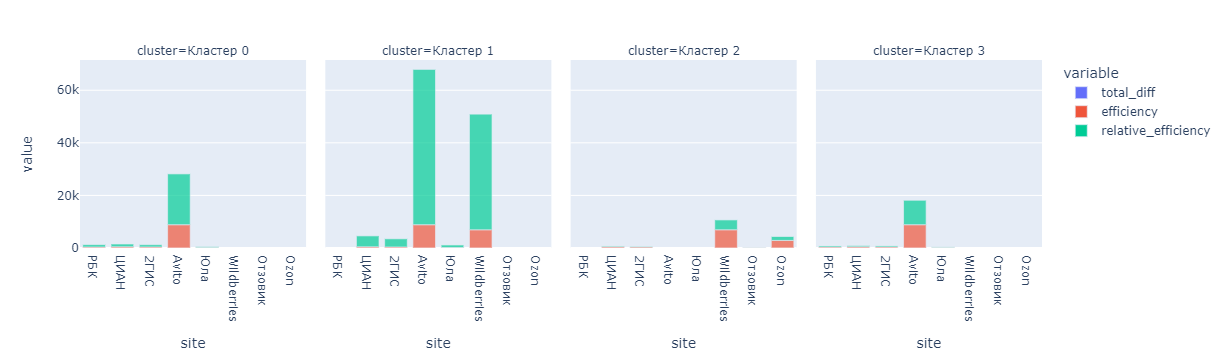

In [189]:
import plotly.express as px
df_top_merged = df_top5.merge(df_media,on='site',how='left')
# df__ = df_top_merged['total_diff']
# df_top_merged['total_diff']=(df__-df__.mean())/df__.std()
df_top_merged['relative_efficiency'] = df_top_merged['efficiency']/df_top_merged['total_diff']
plt_topscat = px.scatter(df_top_merged,'efficiency','total_diff','cluster','site')
plt_topbar = px.bar(df_top_merged,'site',['total_diff','efficiency','relative_efficiency'],facet_col='cluster',opacity=0.7)
# plt_ef_dif = px.bar(df_top_merged,'site',,facet_col='cluster')
plt_topbar

In [190]:
import pickle as pkl

pkl.dump(plt_topbar, open( "plt_topbar.pkl", "wb" ) )
pkl.dump(plt_topscat, open( "plt_topscat.pkl", "wb" ) )

In [186]:
plt_topbar = pkl.load(open( "plt_topbar.pkl", "rb" ) )
plt_topscat = pkl.load(open( "plt_topscat.pkl", "rb" ) )

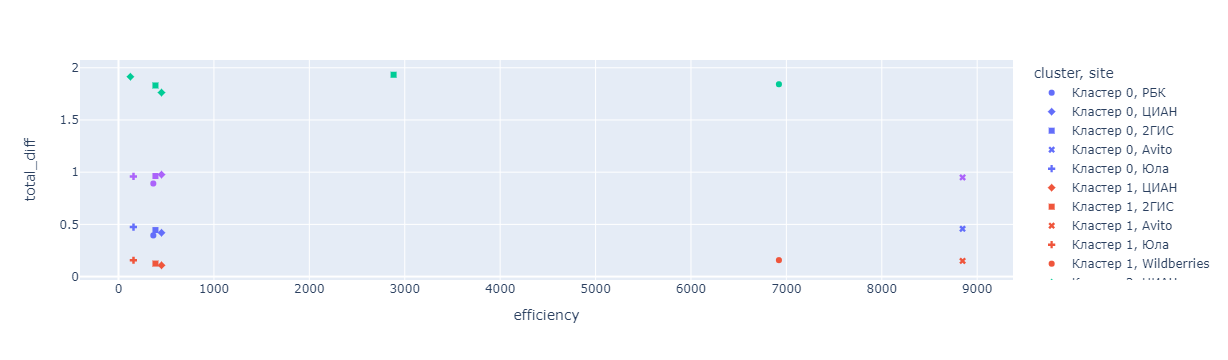

In [187]:
plt_topscat